In [1]:
import pandas as pd
import cenpy as c
import cenpy.tiger as tiger
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.parser import parse
%matplotlib inline

In [2]:
# Read two datasets into dataframes and concatenate into one dataset: crime_df

crime_17_df = pd.read_csv("data/chicago_crime_2017.csv")
crime_18_df = pd.read_csv("data/chicago_crime_2018.csv")
crime_df = pd.concat([crime_17_df, crime_18_df])

# Drop all rows with NAs in Latitude and Longitude

crime_df = crime_df.dropna(subset=["Latitude", "Longitude"])

In [3]:
#Create a shapely dataframe using Latitude and Longitude of crime_df: crime_gdf
crime_df["Coordinates"] = list(zip(crime_df.Longitude, crime_df.Latitude))
crime_df["Coordinates"] = crime_df["Coordinates"].apply(Point)
crime_gdf = gpd.GeoDataFrame(crime_df, geometry='Coordinates')
crime_gdf = crime_gdf[["Date", "Block", "Primary Type", "Community Area", "Year", "Coordinates"]]
crime_gdf.crs = {'init' :'epsg:4326'}

In [4]:
# 5-Year ACS Dataset for 2017
dataset = "ACSDT5Y2017"
c.explorer.explain(dataset)

{'ACS 5-Year Detailed Tables': 'The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population.  Summary files include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts (114th congress), all counties, all places, and all tracts and block groups.  Summary files contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population and housing counts. There are over 64,000 variables in this dataset.'}

In [5]:
# Connect to the dataset
conn = c.base.Connection("ACSDT5Y2017")
conn

Connection to ACS 5-Year Detailed Tables (ID: https://api.census.gov/data/id/ACSDT5Y2017)

I will be augmenting the crime dataset with block group-level data with:

1. Median Household Income (B19013_001E)
2. Educational Attainment
3. Race

In [6]:
# Querying for Dataset

variables = ["B19013_001E", "GEO_ID"]
geo_unit = "block group:*"
geo_filter = {'state': '17', 'county': '031'}

acs_df = conn.query(variables, geo_unit=geo_unit, geo_filter=geo_filter)
acs_df.rename(columns={'B19013_001E':'Income'}, inplace=True)

# Drop median income below 0

acs_df["Income"] = acs_df["Income"].astype(int)
acs_df = acs_df[acs_df.Income > 0]

In [7]:
# Format GEO_ID so that I can merge this dataset with the Chicago Crime Dataset

acs_df['GEO_ID'] = acs_df['GEO_ID'].str.replace(r'1500000US', '')

In [8]:
acs_df.head()

,Income,GEO_ID,state,county,tract,block group
0,21500,170312519001,17,031,251900,1
1,32143,170312519002,17,031,251900,2
2,57000,170318211011,17,031,821101,1
3,65699,170318211013,17,031,821101,3
4,97656,170318211012,17,031,821101,2


Since the Chicago Crime Dataset is based on blocks, I need to b

In [9]:
conn.set_mapservice("tigerWMS_ACS2017")
acs_geodata = conn.mapservice.query(layer=10, where='STATE = 17')
acs_geodata = acs_geodata[["GEOID", "geometry"]]
acs_geodata.rename(columns={'GEOID':'GEO_ID'}, inplace=True)

In [10]:
acs_geodata.head()

,GEO_ID,geometry
0,170318091003,"POLYGON ((-9763920.5912 5169700.912799999, -97..."
1,170312315004,POLYGON ((-9764807.139599999 5145329.259800002...
2,170315703002,POLYGON ((-9765878.144400001 5131687.360299997...
3,170315703003,"POLYGON ((-9766164.2355 5132229.018799998, -97..."
4,170315704001,POLYGON ((-9765208.557700001 5132245.446699999...


In [11]:
# Merge acs_df and acs_geodata
merged_acs_df = pd.merge(acs_df, acs_geodata, on=["GEO_ID"])

In [12]:
merged_acs_df.head()

,Income,GEO_ID,state,county,tract,block group,geometry
0,21500,170312519001,17,031,251900,1,"POLYGON ((-9769437.9191 5144121.124499999, -97..."
1,32143,170312519002,17,031,251900,2,POLYGON ((-9769286.969900001 5144123.965599999...
2,57000,170318211011,17,031,821101,1,"POLYGON ((-9770930.8248 5121809.673900001, -97..."
3,65699,170318211013,17,031,821101,3,"POLYGON ((-9769713.3235 5121783.567000002, -97..."
4,97656,170318211012,17,031,821101,2,"POLYGON ((-9769458.0679 5122334.661200002, -97..."


However, because the spatial data for this merged dataset is in a different format as the Chicago Crime Dataset, I must first convert it before I can spatial join two datasets.

In [13]:
merged_acs_gdf = gpd.GeoDataFrame(merged_acs_df, geometry='geometry')
merged_acs_gdf.crs = {'init' :'epsg:3395'}
merged_acs_gdf = merged_acs_gdf.to_crs({'init': 'epsg:4326'})

In [ ]:
merged_acs_gdf.head()

,Income,GEO_ID,state,county,tract,block group,geometry
0,21500,170312519001,17,031,251900,1,POLYGON ((-87.76035399984343 42.07862040589041...
1,32143,170312519002,17,031,251900,2,POLYGON ((-87.75899800010858 42.07863941933646...
2,57000,170318211011,17,031,821101,1,POLYGON ((-87.77376499992401 41.92912889770044...
3,65699,170318211013,17,031,821101,3,POLYGON ((-87.76282799966177 41.92895376862047...
4,97656,170318211012,17,031,821101,2,POLYGON ((-87.76053499959339 41.93265049003839...


In [ ]:
# Spatial join Chicago Crime Dataset and ACS Dataset
crime_bg_df = gpd.sjoin(crime_gdf, merged_acs_gdf, how="right", op='within')
crime_bg_df = crime_bg_df.reset_index()
crime_bg_df = crime_bg_df[["Date", "Block", "Primary Type", "Community Area", "Year", "Income", "GEO_ID", "geometry"]]
crime_bg_df = crime_bg_df.dropna()
crime_bg_df["Income"] = crime_bg_df["Income"].astype(int)
crime_bg_df["Year"] = crime_bg_df["Year"].astype(int)
crime_bg_df["GEO_ID"] = crime_bg_df["GEO_ID"].astype(int)

In [ ]:
crime_bg_df.head()

,Date,Block,Primary Type,Community Area,Year,Income,GEO_ID,geometry
0,06/03/2017 10:06:00 PM,030XX N LOTUS AVE,OTHER OFFENSE,19.0,2017,57000,170318211011,POLYGON ((-87.77376499992401 41.92912889770044...
1,10/01/2017 04:40:00 PM,030XX N LINDER AVE,BATTERY,19.0,2017,57000,170318211011,POLYGON ((-87.77376499992401 41.92912889770044...
2,05/05/2017 06:20:00 PM,030XX N LOTUS AVE,THEFT,19.0,2017,57000,170318211011,POLYGON ((-87.77376499992401 41.92912889770044...
3,08/30/2017 06:15:00 PM,030XX N LOTUS AVE,CRIMINAL DAMAGE,19.0,2017,57000,170318211011,POLYGON ((-87.77376499992401 41.92912889770044...
4,09/14/2017 01:30:00 PM,030XX N LOTUS AVE,THEFT,19.0,2017,57000,170318211011,POLYGON ((-87.77376499992401 41.92912889770044...


In [ ]:
crime_bg_df['Date'] = crime_bg_df['Date'].astype('datetime64[ns]')

In [ ]:
crime_bg_df["Date"]

0        2017-06-03 22:06:00
1        2017-10-01 16:40:00
2        2017-05-05 18:20:00
3        2017-08-30 18:15:00
4        2017-09-14 13:30:00
5        2018-03-17 21:39:00
6        2018-05-12 21:00:00
7        2017-04-04 15:15:00
8        2017-01-23 21:00:00
9        2017-02-03 21:40:00
10       2018-07-05 07:39:00
11       2018-08-25 01:00:00
12       2017-12-04 14:35:00
13       2017-10-21 15:00:00
14       2017-04-03 00:10:00
15       2017-12-08 16:00:00
16       2017-10-30 17:30:00
17       2017-09-25 09:00:00
18       2018-06-21 21:30:00
19       2018-06-21 21:30:00
20       2018-10-23 16:03:00
21       2018-01-14 22:00:00
22       2018-02-02 09:00:00
23       2018-05-16 17:30:00
24       2017-06-23 08:16:00
25       2018-09-30 13:46:00
26       2018-09-20 13:00:00
27       2018-08-18 08:30:00
28       2018-05-16 12:30:00
29       2018-09-16 04:30:00
                 ...        
505042   2017-06-19 13:00:00
505043   2017-10-23 10:50:00
505044   2017-09-06 07:50:00
505045   2017-

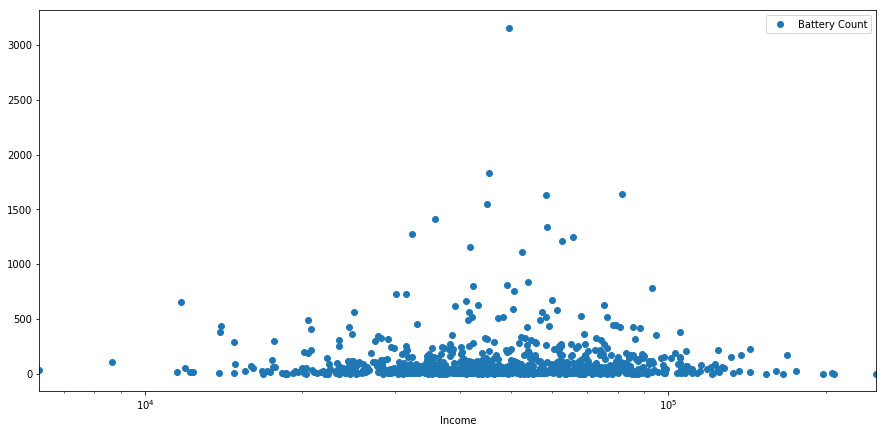

In [ ]:
bat_df = pd.DataFrame(crime_bg_df[crime_bg_df["Primary Type"] == "BATTERY"].groupby(["GEO_ID"]).mean()["Income"])
bat_df["Battery Count"] = crime_bg_df[crime_bg_df["Primary Type"] == "BATTERY"].groupby(["GEO_ID"]).size()
bat_df.plot(x="Income", y="Battery Count", style='o', figsize=(15,7), logx=True)

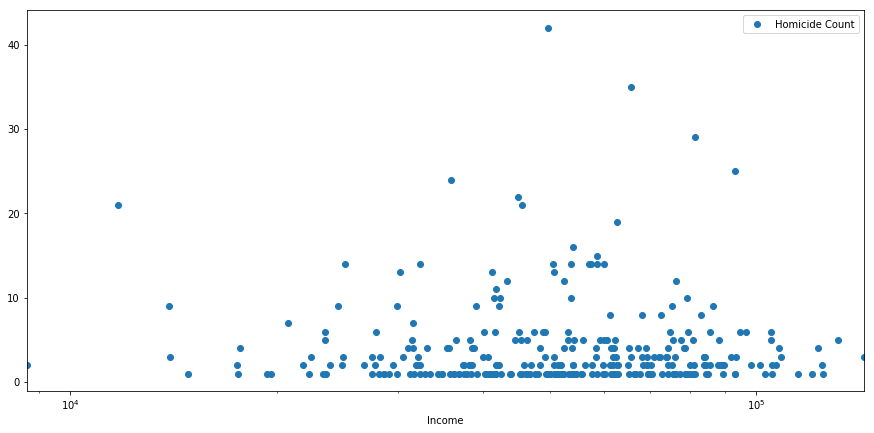

In [ ]:
hom_df = pd.DataFrame(crime_bg_df[crime_bg_df["Primary Type"] == "HOMICIDE"].groupby(["GEO_ID"]).mean()["Income"])
hom_df["Homicide Count"] = crime_bg_df[crime_bg_df["Primary Type"] == "HOMICIDE"].groupby(["GEO_ID"]).size()
hom_df.plot(x="Income", y="Homicide Count", style='o', figsize=(15,7), logx=True)

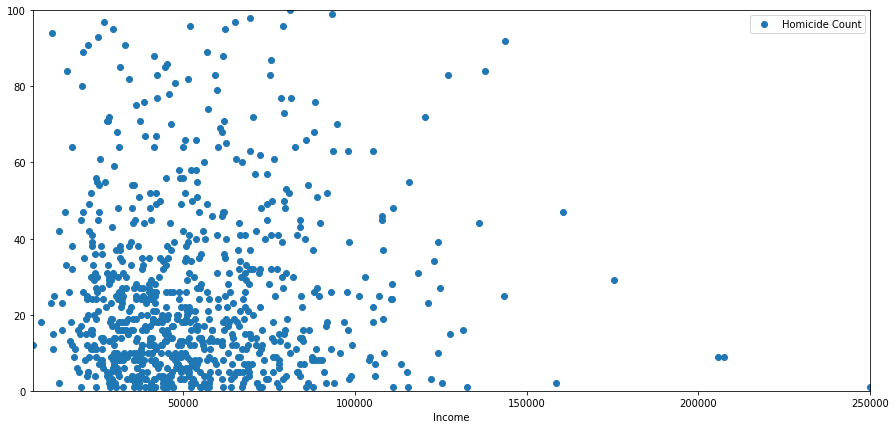

In [ ]:
hom_df = pd.DataFrame(crime_bg_df[crime_bg_df["Primary Type"] == "DECEPTIVE PRACTICE"].groupby(["GEO_ID"]).mean()["Income"])
hom_df["Homicide Count"] = crime_bg_df[crime_bg_df["Primary Type"] == "DECEPTIVE PRACTICE"].groupby(["GEO_ID"]).size()
hom_df.plot(x="Income", y="Homicide Count", style='o', figsize=(15,7), ylim=(0, 100))

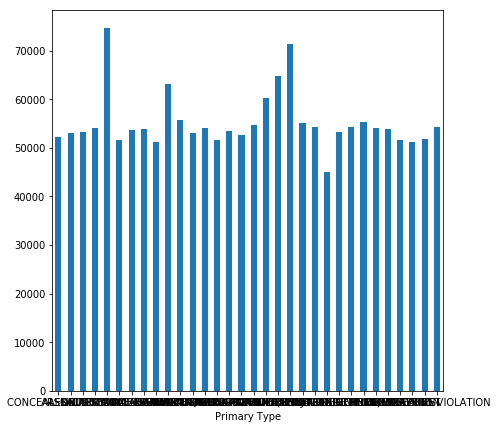

In [ ]:
crime_bg_df.groupby(['Primary Type']).mean()['Income'].plot(kind='bar', figsize=(7, 7), rot=0)

In [ ]:
corr_vars = list(crime_bg_df.columns)
corr_vars.extend(['HOMICIDE', 'BATTERY', 'DECEPTIVE PRACTICE'])

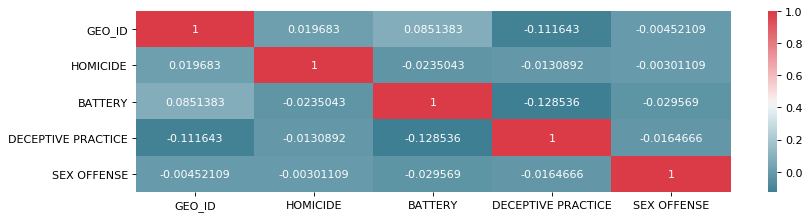

In [ ]:
crime_bg_df_t = pd.concat([crime_bg_df, pd.get_dummies(crime_bg_df['Primary Type'])], axis=1)
corr = crime_bg_df_t[['GEO_ID', 'HOMICIDE', 'BATTERY', 'DECEPTIVE PRACTICE', 'SEX OFFENSE']].corr()
fig = plt.figure(figsize=(12, 3), dpi=80) 
sns.heatmap(corr, annot=True, fmt='g', cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

In [ ]:
crime_bg_df.head()

,Date,Block,Primary Type,Community Area,Year,Income,GEO_ID,geometry
0,2017-06-03 22:06:00,030XX N LOTUS AVE,OTHER OFFENSE,19.0,2017,57000,170318211011,POLYGON ((-87.77376499992401 41.92912889770044...
1,2017-10-01 16:40:00,030XX N LINDER AVE,BATTERY,19.0,2017,57000,170318211011,POLYGON ((-87.77376499992401 41.92912889770044...
2,2017-05-05 18:20:00,030XX N LOTUS AVE,THEFT,19.0,2017,57000,170318211011,POLYGON ((-87.77376499992401 41.92912889770044...
3,2017-08-30 18:15:00,030XX N LOTUS AVE,CRIMINAL DAMAGE,19.0,2017,57000,170318211011,POLYGON ((-87.77376499992401 41.92912889770044...
4,2017-09-14 13:30:00,030XX N LOTUS AVE,THEFT,19.0,2017,57000,170318211011,POLYGON ((-87.77376499992401 41.92912889770044...


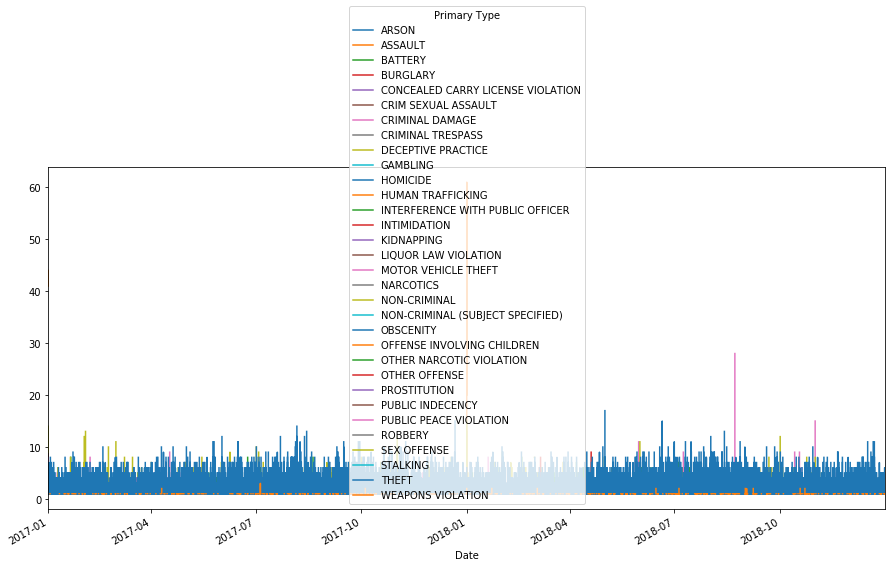

In [ ]:
crime_bg_df.groupby(['Date', 'Primary Type']).size().unstack().plot(figsize = (15,7))

In [ ]:
crime_bg_df.groupby(['GEO_ID', 'Primary Type']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,7))

In [ ]:
hom_df = crime_bg_df[(crime_bg_df['Primary Type'] == "HOMICIDE") | (crime_bg_df['Primary Type'] == "BATTERY")]

In [ ]:
# create weekday column
hom_df['weekday'] = hom_df['Date'].dt.dayofweek

# visualize service requests by weekday
hom_df.groupby(['weekday', 'Primary Type']).size().unstack().plot(figsize=(10,5))

In [ ]:
hom_df.groupby(['Date', 'Primary Type']).size().unstack().plot(figsize=(15,7))